In [1]:
import init
import os
import argparse
import sys
import logging
import cv2

sys.path.insert(0, 'lib')
from configs.faster.default_configs import config, update_config
import numpy as np

# get config
os.environ['PYTHONUNBUFFERED'] = '1'
os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'
os.environ['MXNET_ENABLE_GPU_P2P'] = '0'
update_config('./configs/faster/res101_mx_3k.yml')

import mxnet as mx
from symbols import *

from bbox.bbox_transform import bbox_pred, clip_boxes
from demo.module import MutableModule
from demo.image import resize, transform
from demo.load_model import load_param
from demo.tictoc import tic, toc
from demo.nms import nms
import pickle
from symbols.faster.resnet_mx_101_e2e_3k_demo import resnet_mx_101_e2e_3k_demo, checkpoint_callback


/SNIPER/configs/faster/default_configs.py:169: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [2]:
# load image list

image_root = './demo/image'
dir_names = ['bugatti', 'cleaner', 'gpu', 'sadcat', 'spiderman']

image_names_full = []
gt_labels_full = []

for idx, d in enumerate(dir_names):
    image_names = [os.path.join(image_root, d, f) for f in os.listdir(os.path.join(image_root, d))
                   if os.path.isfile(os.path.join(image_root, d, f)) and f.split('.')[-1] in ['jpg', 'png']]

    image_names_full = image_names_full + image_names
    gt_labels_full.extend([idx] * len(image_names))

In [3]:
# load and transform images

data = []
im_list = []
im_info_list = []

print('Load and transform images...')
for idx, im_name in enumerate(image_names_full):
    assert os.path.exists(im_name), ('{} does not exist'.format(im_name))

    im = cv2.imread(im_name, cv2.IMREAD_COLOR | 128)
    target_size = config.TEST.SCALES[0][0]
    max_size = config.TEST.SCALES[0][1]

    im, im_scale = resize(im, target_size, max_size, stride=config.network.RPN_FEAT_STRIDE)
    im_tensor = transform(im, config.network.PIXEL_MEANS)
    im_info = np.array([[im_tensor.shape[2], im_tensor.shape[3], im_scale]], dtype=np.float32)

    im_list.append(im)
    im_info_list.append(im_info)
    data.append({'data': im_tensor, 'im_info': im_info})

    if (idx + 1) % 100 == 0:
        print('{}/{}'.format(idx + 1, len(image_names_full)))

print('Done')

Load and transform images...
100/543
200/543
300/543
400/543
500/543
Done


In [4]:
# symbol preparation

data_names = ['data', 'im_info']
label_names = []

data = [[mx.nd.array(data[i][name]) for name in data_names] for i in range(len(data))]
max_data_shape = [[('data', (1, 3, max([v[0] for v in config.TEST.SCALES]), max([v[1] for v in config.TEST.SCALES])))]]

provide_data = [[(k, v.shape) for k, v in zip(data_names, d)] for d in data]
provide_label = [None for _ in data]

output_path = './output/chips_resnet101_3k/res101_mx_3k/fall11_whole/'
model_prefix = os.path.join(output_path, 'CRCNN')

arg_params, aux_params = load_param(model_prefix, config.TEST.TEST_EPOCH,
                                    convert=True, process=True)

In [5]:
# set feature extractor

feat_extractor_sym = resnet_mx_101_e2e_3k_demo().get_symbol_rcnn(config, is_train=False)
feat_extractor = MutableModule(feat_extractor_sym, data_names, label_names,
                               context=[mx.gpu(0)],
                               max_data_shapes=max_data_shape)
feat_extractor.bind(provide_data, provide_label, for_training=False)
feat_extractor.init_params(arg_params=arg_params, aux_params=aux_params)

In [6]:
# feature extraction

features = []

print("Extract features...")
tic()

for idx, d in enumerate(data):
    data_batch = mx.io.DataBatch(data=[d], label=[], pad=0, index=idx,
                                 provide_data=[[(k, v.shape) for k, v in zip(data_names, d)]],
                                 provide_label=[None])
    feat_extractor.forward(data_batch)
    conv5_feat = feat_extractor.get_outputs()[4]
    pooled_feat = mx.ndarray.Pooling(data=conv5_feat, pool_type='avg', global_pool=True, kernel=(7, 7))
    features.append(pooled_feat.reshape((1, -1)).asnumpy())

    if (idx + 1) % 100 == 0:
        print('{}/{}: {:.4f} seconds spent.'.format(idx + 1, len(image_names_full), toc()))

print('Done')

Extract features...
100/543: 5.7614 seconds spent.
200/543: 11.5162 seconds spent.
300/543: 17.1735 seconds spent.
400/543: 22.1085 seconds spent.
500/543: 27.6237 seconds spent.
Done


In [7]:
# split train val sets

def split_train_val(data, labels, num_of_classes, num_val_per_class):
    """
    split features and labels to train and val sets.
    num_val_per_class: currently there's roughly 100 pics for each class; this determines the number of pics used
                        for evaluation per class.
    """
    #splits = []
    train_data = []
    train_labels = []
    eval_data = []
    eval_labels = []
    eval_list = []

    labels = np.array(labels)
    for c in range(num_of_classes):
        indices_c = np.where(labels == c)[0]
        np.random.shuffle(indices_c)
        eval_list.extend(indices_c[:num_val_per_class])
    eval_list.sort()

    for i, (d, lb) in enumerate(zip(data, labels)):
        if i in eval_list:
            eval_data.append(d)
            eval_labels.append(lb)
        else:
            train_data.append(d)
            train_labels.append(lb)

    return train_data, train_labels, eval_data, eval_labels, eval_list

train_data, train_labels, eval_data, eval_labels, eval_list = split_train_val(features, gt_labels_full, len(dir_names), 5)

In [8]:
# train the linear classifier, get trained classifier and eval_list

def get_symbol(logger, num_of_classes):
    """
    Symbol of linear classifier
    """
    X = mx.sym.Variable('data')
    Y = mx.sym.Variable("softmax_label")
    fc1 = mx.sym.FullyConnected(data=X, name='fc1', num_hidden=num_of_classes)
    softmax = mx.sym.SoftmaxOutput(data=fc1, label=Y, name='softmax')

    model = mx.mod.Module(symbol=softmax, data_names=['data'], label_names=['softmax_label'],
                            logger=logger, context=mx.gpu())
    return model

batch_size = 100
learning_rate = 0.001
momentum = 0.9
num_epoch = 250
num_of_classes = len(dir_names)

train_data = np.concatenate(train_data)
train_labels = np.array(train_labels)
train_iter = mx.io.NDArrayIter(train_data, train_labels, batch_size, shuffle=True)

eval_data = np.concatenate(eval_data)
eval_labels = np.array(eval_labels)
eval_iter = mx.io.NDArrayIter(eval_data, eval_labels, 1, shuffle=False)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

linear_classifier = get_symbol(logger, num_of_classes)
linear_classifier.fit(train_iter, eval_iter, optimizer='sgd',
          optimizer_params={'learning_rate':learning_rate, 'momentum': momentum},
          num_epoch=num_epoch, eval_metric='acc', batch_end_callback = mx.callback.Speedometer(batch_size, 2))

INFO:root:Epoch[0] Batch [2]	Speed: 116621.83 samples/sec	accuracy=0.376667
INFO:root:Epoch[0] Batch [4]	Speed: 50898.66 samples/sec	accuracy=0.795000
INFO:root:Epoch[0] Train-accuracy=0.900000
INFO:root:Epoch[0] Time cost=0.013
INFO:root:Epoch[0] Validation-accuracy=0.920000
INFO:root:Epoch[1] Batch [2]	Speed: 121945.17 samples/sec	accuracy=0.953333
INFO:root:Epoch[1] Batch [4]	Speed: 62963.36 samples/sec	accuracy=0.920000
INFO:root:Epoch[1] Train-accuracy=0.960000
INFO:root:Epoch[1] Time cost=0.013
INFO:root:Epoch[1] Validation-accuracy=1.000000
INFO:root:Epoch[2] Batch [2]	Speed: 116947.00 samples/sec	accuracy=0.980000
INFO:root:Epoch[2] Batch [4]	Speed: 64030.29 samples/sec	accuracy=0.950000
INFO:root:Epoch[2] Train-accuracy=0.990000
INFO:root:Epoch[2] Time cost=0.012
INFO:root:Epoch[2] Validation-accuracy=1.000000
INFO:root:Epoch[3] Batch [2]	Speed: 121644.55 samples/sec	accuracy=0.983333
INFO:root:Epoch[3] Batch [4]	Speed: 63081.73 samples/sec	accuracy=0.980000
INFO:root:Epoch[3]

INFO:root:Epoch[29] Batch [4]	Speed: 83510.28 samples/sec	accuracy=0.990000
INFO:root:Epoch[29] Train-accuracy=1.000000
INFO:root:Epoch[29] Time cost=0.011
INFO:root:Epoch[29] Validation-accuracy=1.000000
INFO:root:Epoch[30] Batch [2]	Speed: 120456.75 samples/sec	accuracy=0.993333
INFO:root:Epoch[30] Batch [4]	Speed: 78959.04 samples/sec	accuracy=0.990000
INFO:root:Epoch[30] Train-accuracy=1.000000
INFO:root:Epoch[30] Time cost=0.011
INFO:root:Epoch[30] Validation-accuracy=1.000000
INFO:root:Epoch[31] Batch [2]	Speed: 126372.52 samples/sec	accuracy=0.993333
INFO:root:Epoch[31] Batch [4]	Speed: 81848.06 samples/sec	accuracy=0.990000
INFO:root:Epoch[31] Train-accuracy=1.000000
INFO:root:Epoch[31] Time cost=0.011
INFO:root:Epoch[31] Validation-accuracy=1.000000
INFO:root:Epoch[32] Batch [2]	Speed: 121065.20 samples/sec	accuracy=0.993333
INFO:root:Epoch[32] Batch [4]	Speed: 82516.31 samples/sec	accuracy=0.990000
INFO:root:Epoch[32] Train-accuracy=1.000000
INFO:root:Epoch[32] Time cost=0.01

INFO:root:Epoch[58] Train-accuracy=1.000000
INFO:root:Epoch[58] Time cost=0.011
INFO:root:Epoch[58] Validation-accuracy=1.000000
INFO:root:Epoch[59] Batch [2]	Speed: 120803.69 samples/sec	accuracy=1.000000
INFO:root:Epoch[59] Batch [4]	Speed: 62206.96 samples/sec	accuracy=0.990000
INFO:root:Epoch[59] Train-accuracy=1.000000
INFO:root:Epoch[59] Time cost=0.012
INFO:root:Epoch[59] Validation-accuracy=1.000000
INFO:root:Epoch[60] Batch [2]	Speed: 123108.42 samples/sec	accuracy=1.000000
INFO:root:Epoch[60] Batch [4]	Speed: 74189.51 samples/sec	accuracy=0.990000
INFO:root:Epoch[60] Train-accuracy=1.000000
INFO:root:Epoch[60] Time cost=0.011
INFO:root:Epoch[60] Validation-accuracy=1.000000
INFO:root:Epoch[61] Batch [2]	Speed: 124737.67 samples/sec	accuracy=1.000000
INFO:root:Epoch[61] Batch [4]	Speed: 75846.37 samples/sec	accuracy=0.990000
INFO:root:Epoch[61] Train-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.011
INFO:root:Epoch[61] Validation-accuracy=1.000000
INFO:root:Epoch[62] Batch

INFO:root:Epoch[87] Time cost=0.011
INFO:root:Epoch[87] Validation-accuracy=1.000000
INFO:root:Epoch[88] Batch [2]	Speed: 127119.38 samples/sec	accuracy=1.000000
INFO:root:Epoch[88] Batch [4]	Speed: 73494.02 samples/sec	accuracy=0.990000
INFO:root:Epoch[88] Train-accuracy=1.000000
INFO:root:Epoch[88] Time cost=0.011
INFO:root:Epoch[88] Validation-accuracy=1.000000
INFO:root:Epoch[89] Batch [2]	Speed: 122802.05 samples/sec	accuracy=1.000000
INFO:root:Epoch[89] Batch [4]	Speed: 79732.04 samples/sec	accuracy=0.990000
INFO:root:Epoch[89] Train-accuracy=1.000000
INFO:root:Epoch[89] Time cost=0.011
INFO:root:Epoch[89] Validation-accuracy=1.000000
INFO:root:Epoch[90] Batch [2]	Speed: 119088.70 samples/sec	accuracy=1.000000
INFO:root:Epoch[90] Batch [4]	Speed: 73391.15 samples/sec	accuracy=0.990000
INFO:root:Epoch[90] Train-accuracy=1.000000
INFO:root:Epoch[90] Time cost=0.012
INFO:root:Epoch[90] Validation-accuracy=1.000000
INFO:root:Epoch[91] Batch [2]	Speed: 110043.39 samples/sec	accuracy=1

INFO:root:Epoch[116] Train-accuracy=1.000000
INFO:root:Epoch[116] Time cost=0.016
INFO:root:Epoch[116] Validation-accuracy=1.000000
INFO:root:Epoch[117] Batch [2]	Speed: 103180.91 samples/sec	accuracy=1.000000
INFO:root:Epoch[117] Batch [4]	Speed: 68194.52 samples/sec	accuracy=0.990000
INFO:root:Epoch[117] Train-accuracy=1.000000
INFO:root:Epoch[117] Time cost=0.013
INFO:root:Epoch[117] Validation-accuracy=1.000000
INFO:root:Epoch[118] Batch [2]	Speed: 103575.85 samples/sec	accuracy=1.000000
INFO:root:Epoch[118] Batch [4]	Speed: 64811.93 samples/sec	accuracy=0.990000
INFO:root:Epoch[118] Train-accuracy=1.000000
INFO:root:Epoch[118] Time cost=0.012
INFO:root:Epoch[118] Validation-accuracy=1.000000
INFO:root:Epoch[119] Batch [2]	Speed: 116865.53 samples/sec	accuracy=1.000000
INFO:root:Epoch[119] Batch [4]	Speed: 69390.42 samples/sec	accuracy=0.990000
INFO:root:Epoch[119] Train-accuracy=1.000000
INFO:root:Epoch[119] Time cost=0.012
INFO:root:Epoch[119] Validation-accuracy=1.000000
INFO:ro

INFO:root:Epoch[145] Batch [4]	Speed: 80497.15 samples/sec	accuracy=0.990000
INFO:root:Epoch[145] Train-accuracy=1.000000
INFO:root:Epoch[145] Time cost=0.011
INFO:root:Epoch[145] Validation-accuracy=0.960000
INFO:root:Epoch[146] Batch [2]	Speed: 118349.44 samples/sec	accuracy=1.000000
INFO:root:Epoch[146] Batch [4]	Speed: 71386.33 samples/sec	accuracy=0.990000
INFO:root:Epoch[146] Train-accuracy=1.000000
INFO:root:Epoch[146] Time cost=0.012
INFO:root:Epoch[146] Validation-accuracy=0.960000
INFO:root:Epoch[147] Batch [2]	Speed: 81190.55 samples/sec	accuracy=1.000000
INFO:root:Epoch[147] Batch [4]	Speed: 45160.74 samples/sec	accuracy=0.990000
INFO:root:Epoch[147] Train-accuracy=1.000000
INFO:root:Epoch[147] Time cost=0.016
INFO:root:Epoch[147] Validation-accuracy=0.960000
INFO:root:Epoch[148] Batch [2]	Speed: 75099.44 samples/sec	accuracy=1.000000
INFO:root:Epoch[148] Batch [4]	Speed: 48121.89 samples/sec	accuracy=0.990000
INFO:root:Epoch[148] Train-accuracy=1.000000
INFO:root:Epoch[148

INFO:root:Epoch[174] Batch [2]	Speed: 126220.40 samples/sec	accuracy=1.000000
INFO:root:Epoch[174] Batch [4]	Speed: 69350.26 samples/sec	accuracy=0.990000
INFO:root:Epoch[174] Train-accuracy=1.000000
INFO:root:Epoch[174] Time cost=0.011
INFO:root:Epoch[174] Validation-accuracy=0.960000
INFO:root:Epoch[175] Batch [2]	Speed: 127428.35 samples/sec	accuracy=1.000000
INFO:root:Epoch[175] Batch [4]	Speed: 71186.42 samples/sec	accuracy=0.990000
INFO:root:Epoch[175] Train-accuracy=1.000000
INFO:root:Epoch[175] Time cost=0.011
INFO:root:Epoch[175] Validation-accuracy=0.960000
INFO:root:Epoch[176] Batch [2]	Speed: 131195.00 samples/sec	accuracy=1.000000
INFO:root:Epoch[176] Batch [4]	Speed: 71459.31 samples/sec	accuracy=0.990000
INFO:root:Epoch[176] Train-accuracy=1.000000
INFO:root:Epoch[176] Time cost=0.011
INFO:root:Epoch[176] Validation-accuracy=0.960000
INFO:root:Epoch[177] Batch [2]	Speed: 127080.87 samples/sec	accuracy=1.000000
INFO:root:Epoch[177] Batch [4]	Speed: 70397.85 samples/sec	ac

INFO:root:Epoch[202] Time cost=0.011
INFO:root:Epoch[202] Validation-accuracy=0.960000
INFO:root:Epoch[203] Batch [2]	Speed: 126965.46 samples/sec	accuracy=1.000000
INFO:root:Epoch[203] Batch [4]	Speed: 69910.89 samples/sec	accuracy=0.990000
INFO:root:Epoch[203] Train-accuracy=1.000000
INFO:root:Epoch[203] Time cost=0.012
INFO:root:Epoch[203] Validation-accuracy=0.960000
INFO:root:Epoch[204] Batch [2]	Speed: 119700.46 samples/sec	accuracy=1.000000
INFO:root:Epoch[204] Batch [4]	Speed: 72191.12 samples/sec	accuracy=0.990000
INFO:root:Epoch[204] Train-accuracy=1.000000
INFO:root:Epoch[204] Time cost=0.011
INFO:root:Epoch[204] Validation-accuracy=0.960000
INFO:root:Epoch[205] Batch [2]	Speed: 120146.20 samples/sec	accuracy=1.000000
INFO:root:Epoch[205] Batch [4]	Speed: 71746.56 samples/sec	accuracy=0.990000
INFO:root:Epoch[205] Train-accuracy=1.000000
INFO:root:Epoch[205] Time cost=0.011
INFO:root:Epoch[205] Validation-accuracy=0.960000
INFO:root:Epoch[206] Batch [2]	Speed: 128758.37 samp

INFO:root:Epoch[231] Batch [4]	Speed: 71617.93 samples/sec	accuracy=0.995000
INFO:root:Epoch[231] Train-accuracy=1.000000
INFO:root:Epoch[231] Time cost=0.011
INFO:root:Epoch[231] Validation-accuracy=0.960000
INFO:root:Epoch[232] Batch [2]	Speed: 122193.85 samples/sec	accuracy=1.000000
INFO:root:Epoch[232] Batch [4]	Speed: 70694.49 samples/sec	accuracy=0.995000
INFO:root:Epoch[232] Train-accuracy=1.000000
INFO:root:Epoch[232] Time cost=0.011
INFO:root:Epoch[232] Validation-accuracy=0.960000
INFO:root:Epoch[233] Batch [2]	Speed: 123579.96 samples/sec	accuracy=1.000000
INFO:root:Epoch[233] Batch [4]	Speed: 78877.37 samples/sec	accuracy=0.995000
INFO:root:Epoch[233] Train-accuracy=1.000000
INFO:root:Epoch[233] Time cost=0.011
INFO:root:Epoch[233] Validation-accuracy=0.960000
INFO:root:Epoch[234] Batch [2]	Speed: 118987.35 samples/sec	accuracy=1.000000
INFO:root:Epoch[234] Batch [4]	Speed: 75729.96 samples/sec	accuracy=0.995000
INFO:root:Epoch[234] Train-accuracy=1.000000
INFO:root:Epoch[2

In [9]:
# extract RoI-pooled features and bounding-boxes for eval set

data_eval = [data[i] for i in eval_list]
im_eval = [im_list[i] for i in eval_list]
im_info_eval = [im_info_list[i] for i in eval_list]

roipooled_features = []
bboxes = []
obj_scores = []

print("Extract RoI-pooled features of eval images...")
tic()

for idx, d in enumerate(data_eval):
    data_batch = mx.io.DataBatch(data=[d], label=[], pad=0, index=idx,
                                 provide_data=[[(k, v.shape) for k, v in zip(data_names, d)]],
                                 provide_label=[None])
    feat_extractor.forward(data_batch)
    rois, scores, bbox_delta, subcls_scores, conv5_feat = feat_extractor.get_outputs()

    roipooled_conv5_feat = mx.ndarray.ROIPooling(data=conv5_feat, rois=rois, pooled_size=(7, 7), spatial_scale=0.0625)
    pooled_feat = mx.ndarray.Pooling(data=roipooled_conv5_feat, pool_type='avg', global_pool=True, kernel=(7, 7))
    roipooled_features.append(pooled_feat.reshape((pooled_feat.shape[0], -1)).asnumpy())

    im_h, im_w, im_scale = im_info_eval[idx][0]
    bboxes_img = bbox_pred(rois.asnumpy().reshape((-1, 5))[:, 1:], np.array([0.1, 0.1, 0.2, 0.2]) * bbox_delta.asnumpy()[0])
    bboxes_img = clip_boxes(bboxes_img, [im_h, im_w])
    bboxes_img = bboxes_img / im_scale
    bboxes.append(bboxes_img)
    obj_scores.append(scores.asnumpy()[:, ])

    if (idx + 1) % 100 == 0:
        print('{}/{}: {:.4f} seconds spent.'.format(idx + 1, len(eval_data), toc()))

print('Done')

Extract RoI-pooled features of eval images...
Done


In [10]:
# classify the rois

def classify_rois(model, roipooled_features):
    """
    evaluate the rois
    """
    rois_classification = []

    for one in roipooled_features:
        rois_iter = mx.io.NDArrayIter([one.reshape((one.shape[0], -1))], np.zeros((one.shape[0])), 100, shuffle=False)
        out = model.predict(rois_iter)
        rois_classification.append(out.asnumpy())
    return rois_classification

cls_scores = classify_rois(linear_classifier, roipooled_features)

In [11]:
# perform NMS

def process_mul_scores(scores, xcls_scores):
    """
    Do multiplication of objectness score and classification score to obtain the final detection score.
    """
    final_scores = np.zeros((scores.shape[0], xcls_scores.shape[1]+1))
    final_scores[:, 1:] = xcls_scores[:, :] * scores[:, [1]]
    return final_scores

def postprocess_rois(bboxes, obj_scores, cls_scores, score_thresh):
    dets = []
    for idx, (bboxes_img, obj_scores_img, cls_scores_img) in enumerate(zip(bboxes, obj_scores, cls_scores)):
        scores_img = process_mul_scores(obj_scores_img[0], cls_scores_img).astype('f')
        bboxes_img = bboxes_img.astype('f')
        dets_img = []

        for c in range(1, scores_img.shape[1]):
            scores_c = scores_img[:, c, np.newaxis]
            boxes_c = bboxes_img[:, 0:4]
            dets_c = np.hstack((boxes_c, scores_c))

            keep = nms(dets_c, 0.45)
            dets_c = dets_c[keep, :]
            dets_c = dets_c[dets_c[:, -1] > float(score_thresh), :]

            dets_img.append(dets_c)
        dets.append(dets_img)
    return dets

score_thresh = 0.5
dets = postprocess_rois(bboxes, obj_scores, cls_scores, score_thresh)

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


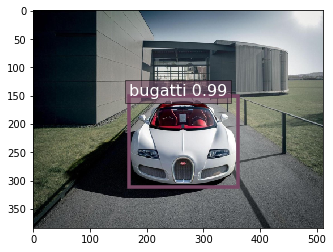

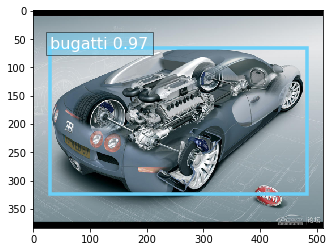

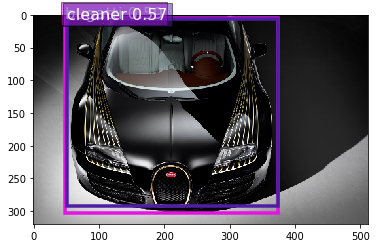

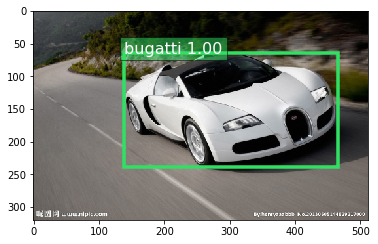

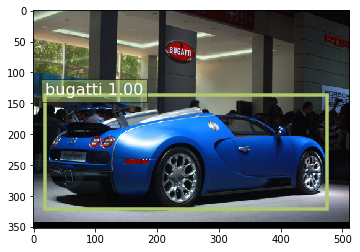

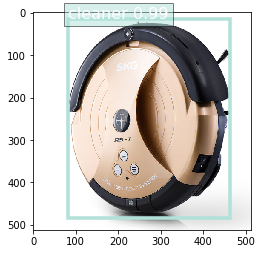

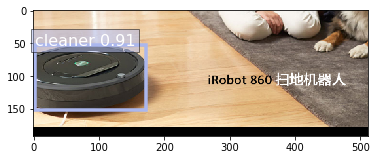

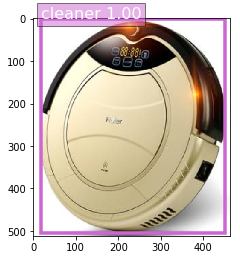

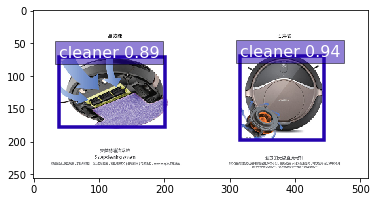

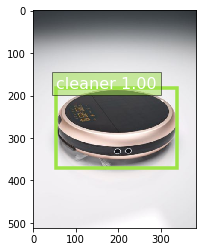

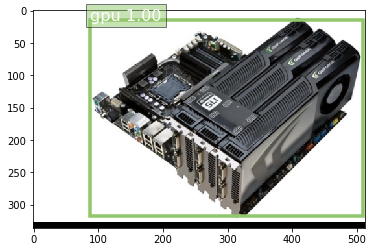

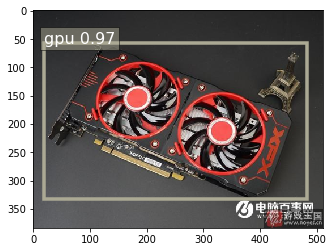

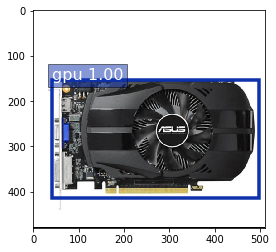

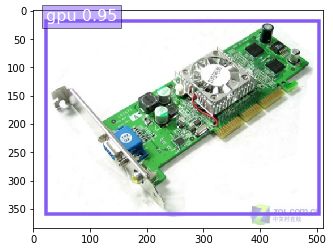

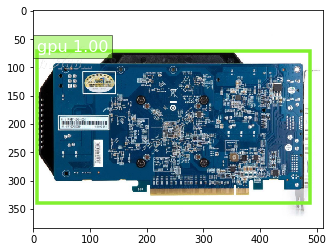

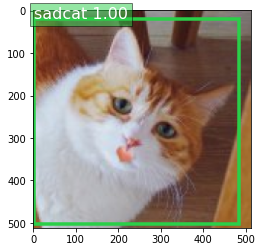

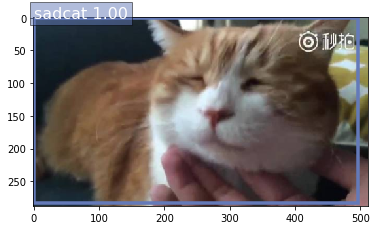

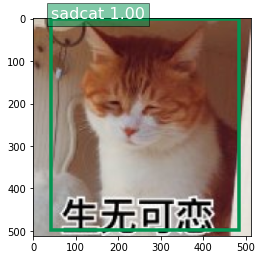

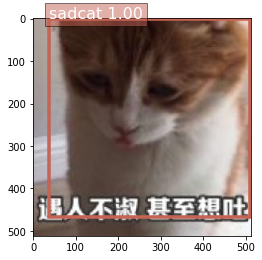

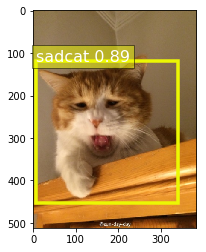

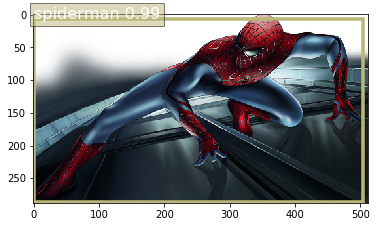

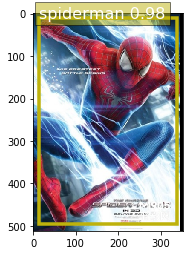

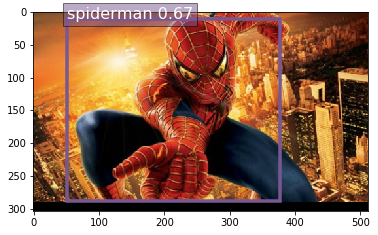

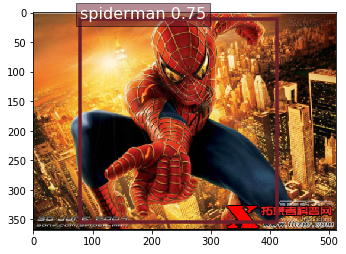

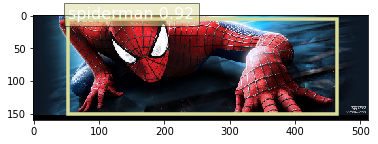

In [12]:
# visualize

import random
import matplotlib.pyplot as plt
%matplotlib inline

def vis_boxes(plt, im_array, detections, scale, cfg, class_names_matching):
    """
    visualize detections in one image
    :param im_array: [b=1 c h w] in rgb
    :param detections: [ numpy.ndarray([[x1 y1 x2 y2 score]]) for j in classes ]
    :param scale: visualize the scaled image
    :param cfg: config
    :return:
    """
    im = im_array
    plt.imshow(im)

    for j in range(len(detections)):
        color = (random.random(), random.random(), random.random())  # generate a random color
        dets_j = detections[j]
        for det in dets_j:
            bbox = det[:4] * scale
            score = det[-1]

            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor=color, linewidth=3.5)
            plt.gca().add_patch(rect)

            plt.gca().text(bbox[0], bbox[1],
                           '{:s} {:.2f}'.format(class_names_matching[j], score),
                           bbox=dict(facecolor=color, alpha=0.5), fontsize=16, color='white')

for idx, (im, info, dets_img) in enumerate(zip(im_eval, im_info_eval, dets)):
    im = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2RGB)
    _, _, im_scale = info[0]
    plt.figure(idx)
    vis_boxes(plt, im, dets_img, im_scale, config, dir_names)